### 載入模組

**`torch` 與 `torch.nn`**: Pytorch。

**`numpy`**: 處理數值數據。

**`matplotlib.pyplot`**: 繪圖函式庫。

**`scipy.integrate.solve_ivp`**: SciPy 提供的高級 ODE 求解器。提供一個高度精確的參考解，用以驗證我們 PINN 模型的準確性。

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp

## CUDA

是由 **NVIDIA** 公司所推出的一個平行運算平台與應用程式設計介面 (API) 模型。徹底改變了圖形處理器 (GPU) 的用途，使其不再僅限於圖形渲染，更能投入到各種複雜的通用計算任務中。

我們先簡單確認我們有連上GPU

In [33]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU name:", torch.cuda.get_device_name(0))
    print("Current GPU memory:")
    print(f"  - Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"  - Allocated memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  - Reserved memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("GPU not available, using CPU for computation")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

test_tensor = torch.randn(3, 3).to(device)
print(f"Test tensor device: {test_tensor.device}")
print(f"Test tensor:\n{test_tensor}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
Current GPU name: Tesla T4
Current GPU memory:
  - Total memory: 14.74 GB
  - Allocated memory: 0.14 GB
  - Reserved memory: 0.20 GB
Using device: cuda
Test tensor device: cuda:0
Test tensor:
tensor([[ 0.0802,  0.3667, -0.5238],
        [ 2.0395, -0.2522,  0.0327],
        [ 0.0299,  1.7280, -0.2807]], device='cuda:0')


### 定義常數

#### `TOTAL_TIME` 總模擬時間

#### `EPOCHS` (訓練週期)

#### `BATCH_SIZE` (批次大小)

#### `LEARNING_RATE` (學習率)

In [34]:
# Gyro
# Radius
R = 1
# Height
H = 0.5
# Mass
M = 0.5
# Moment of inertia
I_1 = 0.25 * M * R **2 + M * H**2
I_2 = 0.25 * M * R **2 + M * H**2
I_3 = 0.5 * M * R **2

# Gravity
g = 9.8

# Initial conditions
THETA_0 = 0.5 * np.pi
PHI_0 = np.pi
PSI_0 = 0

D_THETA_0 = 0
D_PHI_0 = -1
D_PSI_0 = 6

# Time
TOTAL_TIME = 2

# Training parameters
EPOCHS = 3000
BATCH_SIZE = 128
LEARNING_RATE = 0.0001


### 定義運動方程

`moment_of_force()` 陀螺儀運動的方程式

In [35]:
def angular_momentum(d_x, I):
    return I[0] * d_x[0] ** 2 + I[1] * d_x[1] ** 2 + I[2] * d_x[2] ** 2

def eularian_transform(x, d_x):

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    omega_1 = phi_dot * torch.sin(theta) * torch.sin(psi) + theta_dot * torch.cos(psi)
    omega_2 = phi_dot * torch.sin(theta) * torch.cos(psi) - theta_dot * torch.sin(psi)
    omega_3 = phi_dot * torch.cos(theta) + psi_dot

    return torch.stack((omega_1, omega_2, omega_3), dim=1)

def moment_of_force(x, d_x, I, M, g, H):
    I_12 = I[0]
    I_3 = I[2]

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)

    epsilon = 1e-10
    condition = torch.abs(sin_theta) < epsilon
    signed_epsilon = torch.copysign(torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), sin_theta)
    signed_epsilon = torch.where(sin_theta == 0, torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), signed_epsilon)
    safe_sin_theta = torch.where(condition, signed_epsilon, sin_theta)

    s_omega_30 = phi_dot * cos_theta + psi_dot

    angular_acceleration_theta = phi_dot**2 * sin_theta * cos_theta - (I_3 / I_12) * phi_dot * sin_theta * s_omega_30 + (M * g * H / I_12) * sin_theta
    angular_acceleration_phi = (theta_dot / (I_12 * safe_sin_theta)) * (I_3 * s_omega_30 - 2 * I_12 * phi_dot * cos_theta)
    angular_acceleration_psi = phi_dot * theta_dot * sin_theta - angular_acceleration_phi * cos_theta


    return torch.stack((angular_acceleration_theta, angular_acceleration_phi, angular_acceleration_psi), dim=1)

### 真實數據模擬

`real_word_simulation()` 用傳統ivp求解運動方程式

In [36]:
def real_word_simulation(time, I, X_0, D_X_0):

  s_I_12 = I[0]
  s_I_3 = I[2]

  s_output = []

  s_theta = X_0[0]
  s_phi = X_0[1]
  s_psi = X_0[2]

  s_theta_dot = D_X_0[0]
  s_phi_dot = D_X_0[1]
  s_psi_dot = D_X_0[2]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot

  if abs(s_sin_theta) < 1e-10:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = 0
    s_psi_dot_dot = 0
  else:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
    s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_output.append([s_theta, s_phi, s_psi, s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  d_t = time[1] - time[0]

  time = time[:-1]

  for _ in time:

    s_theta = s_output[-1][0]
    s_phi = s_output[-1][1]
    s_psi = s_output[-1][2]

    s_theta_dot = s_output[-1][3]
    s_phi_dot = s_output[-1][4]
    s_psi_dot = s_output[-1][5]

    s_sin_theta = np.sin(s_theta)
    s_cos_theta = np.cos(s_theta)

    if abs(s_sin_theta) < 1e-5:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = 0
      s_psi_dot_dot = 0

    else:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
      s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

    s_output.append([s_theta + s_theta_dot * d_t, s_phi + s_phi_dot * d_t, s_psi + s_psi_dot * d_t, s_theta_dot + s_theta_dot_dot * d_t, s_phi_dot + s_phi_dot_dot * d_t, s_psi_dot + s_psi_dot_dot * d_t, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  return np.array(s_output)

def real_word_simulation_solve_ivp_fun(time, y, I, M, g, H):
  s_I_12 = I[0]
  s_I_3 = I[2]

  s_theta = y[0]
  s_phi = y[1]
  s_psi = y[2]

  s_theta_dot = y[3]
  s_phi_dot = y[4]
  s_psi_dot = y[5]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)


  epsilon = 1e-10
  if abs(s_sin_theta) < epsilon:
    s_safe_sin_theta = np.sign(s_sin_theta) * epsilon + (1 - np.sign(s_sin_theta) ** 2) * epsilon
    if abs(s_safe_sin_theta) < epsilon:
      s_safe_sin_theta = epsilon
  else:
    s_safe_sin_theta = s_sin_theta

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot

  s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
  s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
  s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_theta_dot_dot = s_phi_dot**2 * s_sin_theta * s_cos_theta - (s_I_3 / s_I_12) * s_phi_dot * s_sin_theta * s_omega_30 + (M * g * H / s_I_12) * s_sin_theta
  s_phi_dot_dot = (s_theta_dot / (s_I_12 * s_safe_sin_theta)) * (s_I_3 * s_omega_30 - 2 * s_I_12 * s_phi_dot * s_cos_theta)
  s_psi_dot_dot = s_phi_dot * s_theta_dot * s_sin_theta - s_phi_dot_dot * s_cos_theta

  return [s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot]

def real_word_simulation_solve_ivp(time, I, X_0, D_X_0, M, g, H):

  y = [X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]]
  y_0 = np.array([X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]])
  s_output = solve_ivp(real_word_simulation_solve_ivp_fun, [time[0], time[-1]], y_0, t_eval=time, args=(I, M, g, H), method='LSODA', rtol=1e-6, atol=1e-6)
  print(s_output.message)

  return np.array(s_output.y).T

### Model 定義

7層線性層，利用 `nn.Tanh` 當作激活函數

輸入： 時間

輸出： 位置

### 向前傳播

為了讓模型不需要花精力在符合初始條檢而只在意高階的修正還有非線性項，我們把模型改成：

$$x(t) = x_0 + t \cdot \dot{x}_0 + t^2 \cdot N(t; \theta)$$

其中：

$x(t)$ 是模型在時間 $t$ 的預測輸出。

$x_0$ 是系統的初始位置，即 $x(0)$。

$\dot{x}_0$ 是系統的初始速度，即 $\frac{dx}{dt}\Big|_{t=0}$。

$N(t; \theta)$ 代表神經網路的輸出，它是一個以時間 $t$ 為輸入、以 $\theta$ 為可訓練參數的函數。

好處在模型只需要專注於物理規則的學習而不是花大量資源再符合初始狀態且同時還需要學習物理規律

In [37]:
class Model(nn.Module):
    def __init__(self, x_0, d_x_0):
        super(Model, self).__init__()
        self.x_0 = x_0
        # self.d_x_0 = nn.Parameter(d_x_0)
        self.d_x_0 = d_x_0
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 128),
            nn.ReLU()
            nn.Linear(128, 3)
        )

    def forward(self, t):
        net_output = self.net(t)
        output = self.x_0 + t * self.d_x_0 + t**2 * net_output
        return output

### 物理資訊神經網路 (PINN) 訓練流程

#### 1. 初始化 (Initialization)

**裝置設定 (`DEVICE`)**: 自動檢測是否有可用的 CUDA GPU，若有則使用 GPU 進行加速運算，否則使用 CPU。

**參數張量化**: 將物理系統的**初始條件** (`X_0`, `D_X_0`) 和**物理參數** (`I`) 轉換為 PyTorch 張量 (Tensor)，並移動到指定的運算裝置上。

**模型實例化 (`model`)**: 根據給定的初始條件，建立我們之前定義的 `Model` 神經網路。

**優化器 (`optimizer`)**: 選擇 `Adam` 優化器。它是一種高效的梯度下降演算法，負責根據計算出的梯度來更新神經網路的所有可訓練參數（權重和偏差）。

**學習率控制器 (`scheduler`)**: 設定了一個 `ReduceLROnPlateau` 排程器。它的作用是**動態調整學習率**：如果在 `patience=200` 個 epochs 內，損失值 `total_loss` 沒有明顯下降，它會自動將當前的學習率乘以 `factor=0.8`（即降低學習率），以幫助模型在後期更精細地收斂。

**損失紀錄 (`loss_data`)**: 建立一個空陣列，用於在訓練過程中儲存每一輪的損失值，以便後續進行分析。

#### 2. `loss_function`

用來衡量神經網路的輸出 `output` 在多大程度上**違反**了已知的物理定律。

整個函數的計算流程如下：

1.  **計算一階與二階導數**:
    
    程式碼利用 `torch.autograd.grad` 自動微分工具，來計算模型輸出 `output` (代表位置對時間的一階導數 (`output_gradient`, 速度) 和**二階導數** (`output_gradient_2`, 加速度)。
    
    `create_graph=True` 用來計算高階導數，它讓 PyTorch 在計算梯度時也建立計算圖，以便進行二次微分。

2.  **計算物理殘差 (Physics Residual)**:

    `predicted_acceleration = moment_of_force(...)`：這一行程式碼**根據物理定律**（我們之前整理的陀螺運動方程式）和模型當前預測的位置 `output` 及速度 `output_gradient`，計算出**理論上應該有**的加速度。
    
    `physics_loss = nn.MSELoss()(...)`：計算**理論加速度** (`predicted_acceleration`) 與**模型輸出二次微分得到的加速度** (`output_gradient_2`) 之間的均方誤差 (MSE)。這個 loss 值就是**物理殘差**。我們的目標是讓這個值趨近於 0，這等同於強迫神經網路的解去滿足物理定律。

3.  **定義總損失 (`total_loss`)**:

    `total_loss = physics_loss`：**優化目標完全來自於物理殘差**。

#### 3. 主訓練迴圈 (The Main Training Loop)

這是一個標準的 PyTorch 訓練迴圈，它會重複執行 `EPOCHS` 次。

在每一個 `epoch` 中：
1.  **生成時間點**: `torch.linspace` 創建一個從 0 到 `TOTAL_TIME` 的時間序列 `time`。

2.  **設定 `requires_grad`**: `time.requires_grad_(True)` 告訴 PyTorch 需要追蹤 `time` 張量的梯度，這是後續對時間 `t` 進行微分的必要前提。

3.  **前向傳播**: `output = model(time)` 將時間點輸入模型，得到模型對應的輸出。

4.  **梯度清零**: `optimizer.zero_grad()` 清除上一輪迭代殘留的梯度。

5.  **計算損失**: 呼叫 `loss_function` 計算出總損失 `total_loss`。

6.  **反向傳播**: `total_loss.backward()` 根據損失值，自動計算出所有模型參數的梯度。

7.  **梯度裁剪**: `clip_grad_norm_` 是一種防止梯度爆炸的技巧，它將梯度的範數限制在一個最大值 `1.0` 以內，有助於穩定訓練。

8.  **更新參數**: `optimizer.step()` 優化器根據計算出的梯度，更新模型的權重。

9.  **更新學習率**: `scheduler.step(total_loss)` 根據當前的 `total_loss` 來判斷是否需要降低學習率。

10. **紀錄與顯示**: 將當輪的各種損失值存入 `loss_data`，並每 100 個 epochs 顯示一次當前的訓練進度和學習率。

In [38]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

X_0 = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).to(DEVICE)
D_X_0 = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).to(DEVICE)
I = torch.tensor([I_1, I_2, I_3], dtype=torch.float32).to(DEVICE)

model = Model(X_0, D_X_0).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=200)

loss_data = []

def loss_function(output, time):
    # 計算一階導數 (速度)
    output_gradient_theta = torch.autograd.grad(
        outputs=output[:,0],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,0]),
        create_graph=True,
        retain_graph=True
    )[0]

    output_gradient_phi = torch.autograd.grad(
        outputs=output[:,1],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,1]),
        create_graph=True,
        retain_graph=True
    )[0]

    output_gradient_psi = torch.autograd.grad(
        outputs=output[:,2],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,2]),
        create_graph=True,
        retain_graph=True
    )[0]

    # 組合速度向量
    output_gradient = torch.cat([output_gradient_theta, output_gradient_phi, output_gradient_psi], dim=1)

    # 計算二階導數 (加速度)
    output_gradient_2_theta = torch.autograd.grad(
        outputs=output_gradient_theta,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_theta),
        create_graph=True,
        retain_graph=True
    )[0]

    output_gradient_2_phi = torch.autograd.grad(
        outputs=output_gradient_phi,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_phi),
        create_graph=True,
        retain_graph=True
    )[0]

    output_gradient_2_psi = torch.autograd.grad(
        outputs=output_gradient_psi,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_psi),
        create_graph=True,
        retain_graph=True
    )[0]

    output_gradient_2 = torch.cat([output_gradient_2_theta, output_gradient_2_phi, output_gradient_2_psi], dim=1)

    predicted_acceleration = moment_of_force(output, output_gradient, I, M, g, H)
    physics_loss = nn.MSELoss()(predicted_acceleration, output_gradient_2)

    initial_position_loss = nn.MSELoss()(output[0], X_0)
    initial_velocity_loss = nn.MSELoss()(output_gradient[0], D_X_0)
    initial_condition_loss = initial_position_loss + initial_velocity_loss

    total_loss = physics_loss

    return total_loss, physics_loss, initial_position_loss, initial_velocity_loss, initial_condition_loss

for epoch in range(EPOCHS):
    model.train()

    time = torch.linspace(0, TOTAL_TIME, BATCH_SIZE).reshape(-1, 1)
    time = time.to(DEVICE)
    time.requires_grad_(True)

    output = model(time)

    optimizer.zero_grad()
    total_loss, physics_loss, initial_position_loss, initial_velocity_loss, initial_condition_loss = loss_function(output, time)

    total_loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step(total_loss)

    loss_data.append([
        initial_condition_loss.item(),
        physics_loss.item(),
        initial_position_loss.item(),
        initial_velocity_loss.item()
    ])

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss.item():.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
print("訓練完成!")

Epoch 1/3000, Loss: 85.316498, LR: 1.00e-04
Epoch 101/3000, Loss: 6.123137, LR: 1.00e-04
Epoch 201/3000, Loss: 4.618730, LR: 1.00e-04
Epoch 301/3000, Loss: 2.741612, LR: 1.00e-04
Epoch 401/3000, Loss: 1.989701, LR: 1.00e-04
Epoch 501/3000, Loss: 1.677785, LR: 1.00e-04
Epoch 601/3000, Loss: 1.830027, LR: 1.00e-04
Epoch 701/3000, Loss: 1.472757, LR: 1.00e-04
Epoch 801/3000, Loss: 1.294091, LR: 1.00e-04
Epoch 901/3000, Loss: 1.132806, LR: 1.00e-04
Epoch 1001/3000, Loss: 1.059361, LR: 1.00e-04
Epoch 1101/3000, Loss: 0.841163, LR: 1.00e-04
Epoch 1201/3000, Loss: 0.622372, LR: 1.00e-04
Epoch 1301/3000, Loss: 0.493919, LR: 1.00e-04
Epoch 1401/3000, Loss: 0.536011, LR: 1.00e-04
Epoch 1501/3000, Loss: 0.384853, LR: 1.00e-04
Epoch 1601/3000, Loss: 0.290965, LR: 1.00e-04
Epoch 1701/3000, Loss: 0.289676, LR: 1.00e-04
Epoch 1801/3000, Loss: 0.241515, LR: 1.00e-04
Epoch 1901/3000, Loss: 0.238536, LR: 1.00e-04
Epoch 2001/3000, Loss: 0.232702, LR: 1.00e-04
Epoch 2101/3000, Loss: 0.261438, LR: 1.00e-04

### 結果檢查

Expected initial position: [1.5707964 3.1415927 0.       ]
Model predicted initial position: [1.5707964 3.1415927 0.       ]
Expected initial velocity: [ 0. -1.  6.]
Model predicted initial velocity: [ 0. -1.  6.]

Final Total Loss: 0.113616


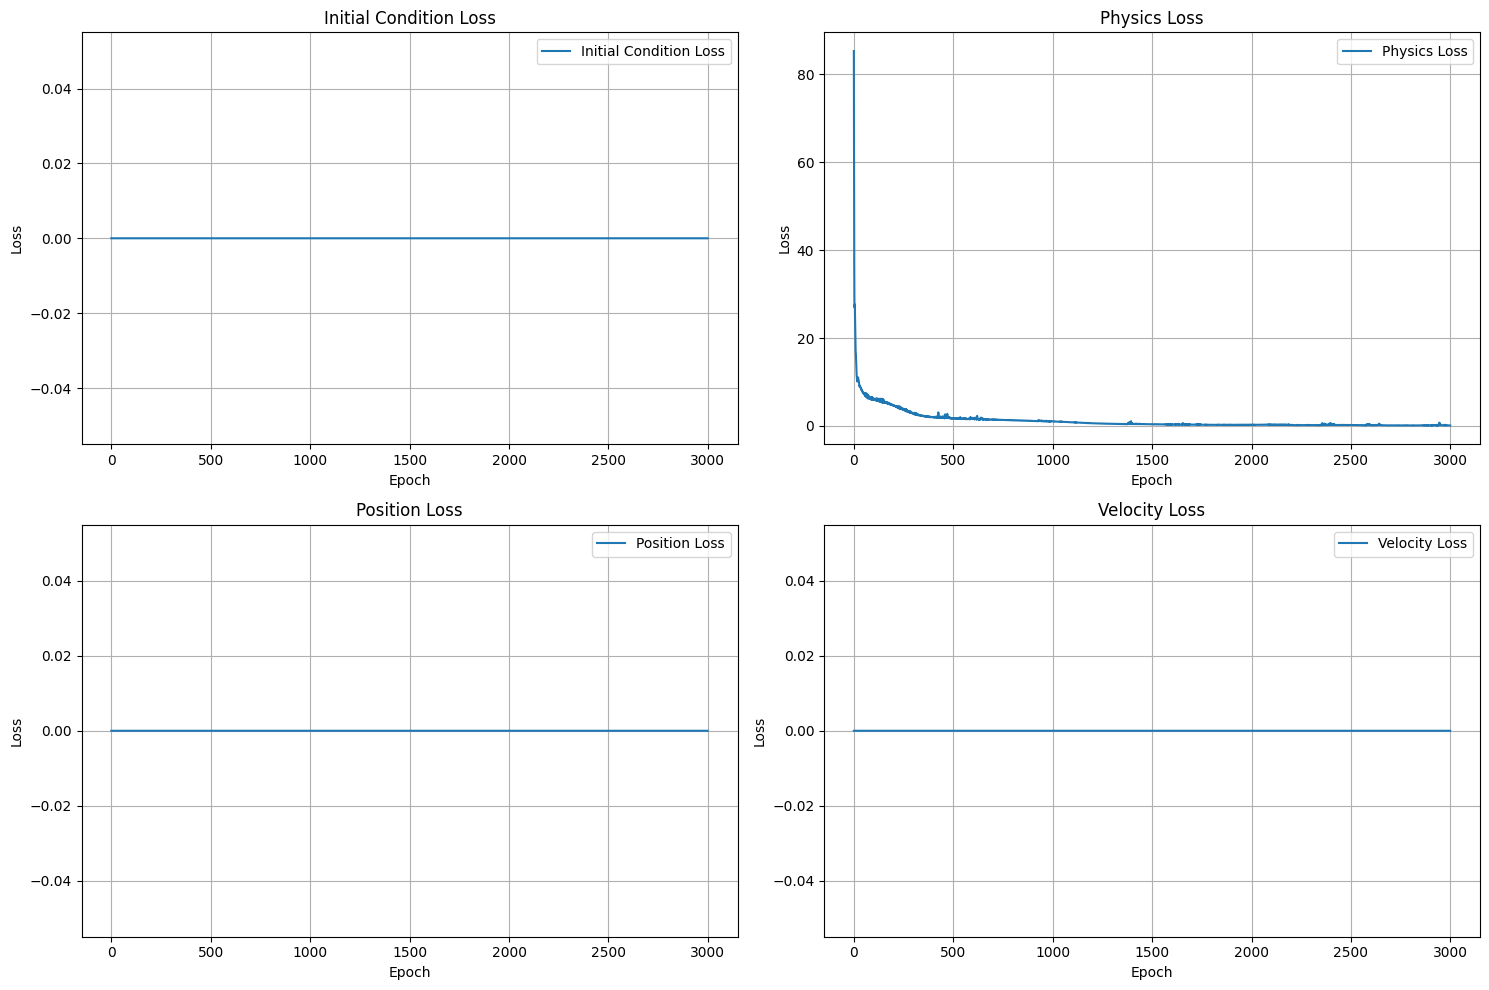

In [39]:
X_0_tensor = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).to(DEVICE)
D_X_0_tensor = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).to(DEVICE)

time_test = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).to(DEVICE)
output_test = model(time_test)

print(f"Expected initial position: {X_0_tensor.cpu().numpy()}")
print(f"Model predicted initial position: {output_test.detach().cpu().numpy().flatten()}")

output_grad_theta_val = torch.autograd.grad(output_test[0,0], time_test, create_graph=True, retain_graph=True)[0].item()
output_grad_phi_val = torch.autograd.grad(output_test[0,1], time_test, create_graph=True, retain_graph=True)[0].item()
output_grad_psi_val = torch.autograd.grad(output_test[0,2], time_test, create_graph=True)[0].item()

predicted_velocity = torch.tensor([output_grad_theta_val, output_grad_phi_val, output_grad_psi_val], device=DEVICE)

print(f"Expected initial velocity: {D_X_0_tensor.cpu().numpy()}")
print(f"Model predicted initial velocity: {predicted_velocity.detach().cpu().numpy()}")

loss_data_array = np.array(loss_data)
print(f"\nFinal Total Loss: {loss_data_array[-1, 1]:.6f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_data_array[:, 0], label='Initial Condition Loss')
plt.title('Initial Condition Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(loss_data_array[:, 1], label='Physics Loss')
plt.title('Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(loss_data_array[:, 2], label='Position Loss')
plt.title('Position Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(loss_data_array[:, 3], label='Velocity Loss')
plt.title('Velocity Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 繪製圖表

The solver successfully reached the end of the integration interval.


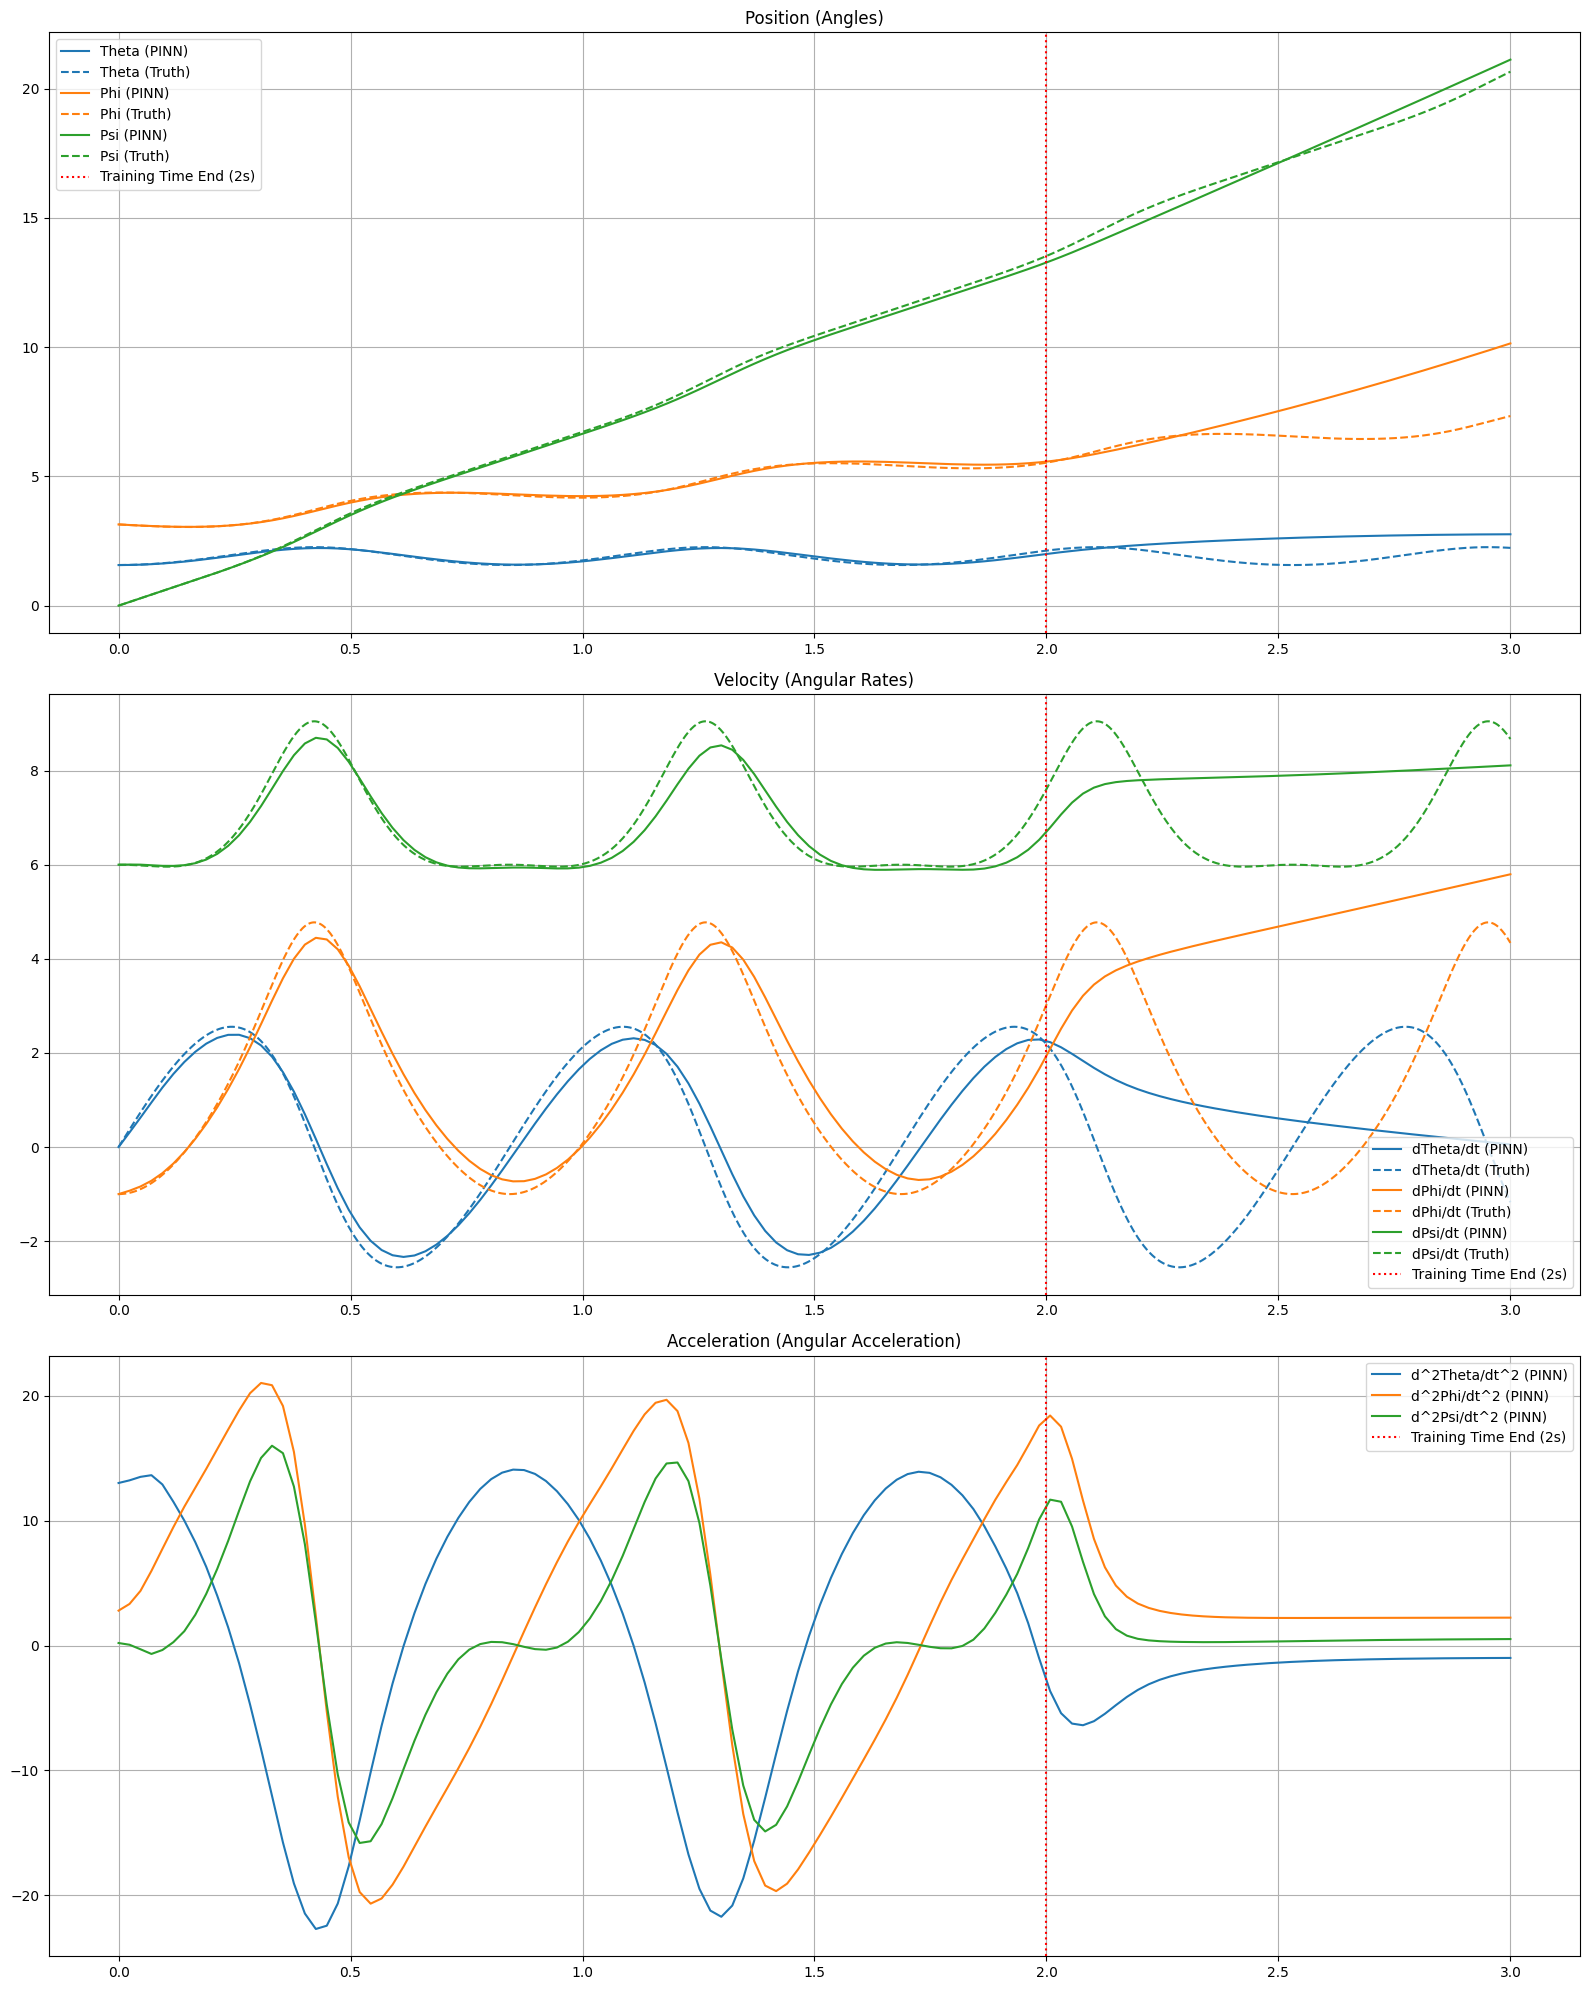

In [40]:
time = np.linspace(0, TOTAL_TIME + 1, BATCH_SIZE).reshape(-1, 1)
time = torch.tensor(time, dtype=torch.float32, requires_grad=True).to(DEVICE)

output = model(time)

output_gradient_theta = torch.autograd.grad(
    outputs=output[:,0],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,0]),
    create_graph=True
)

output_grident_2_theta = torch.autograd.grad(
    outputs=output_gradient_theta[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_theta[0]),
    create_graph=True
)

output_gradient_phi = torch.autograd.grad(
    outputs=output[:,1],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,1]),
    create_graph=True
)

output_grident_2_phi = torch.autograd.grad(
    outputs=output_gradient_phi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_phi[0]),
    create_graph=True
)

output_gradient_psi = torch.autograd.grad(
    outputs=output[:,2],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,2]),
    create_graph=True
)

output_grident_2_psi = torch.autograd.grad(
    outputs=output_gradient_psi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_psi[0]),
    create_graph=True
)

output_gradient = torch.cat((output_gradient_theta[0].unsqueeze(1), output_gradient_phi[0].unsqueeze(1), output_gradient_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)
output_gradient_2 = torch.cat((output_grident_2_theta[0].unsqueeze(1), output_grident_2_phi[0].unsqueeze(1), output_grident_2_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)

output_gradient = output_gradient.detach().cpu().numpy()
output_gradient_2 = output_gradient_2.detach().cpu().numpy()

time = time.detach().cpu().numpy()
output = output.detach().cpu().numpy()

time_sim = np.linspace(0, TOTAL_TIME + 1, 1000)

X_0 = np.array([THETA_0, PHI_0, PSI_0])
D_X_0 = np.array([D_THETA_0, D_PHI_0, D_PSI_0])
I = np.array([I_1, I_2, I_3])
# output_sim = real_word_simulation(time_sim, I, X_0, D_X_0)
output_sim = real_word_simulation_solve_ivp(time_sim, I, X_0, D_X_0, M, g, H)

plt.figure(figsize=(16, 20))

plt.subplot(3, 1, 1)
plt.plot(time, output[:, 0], label='Theta (PINN)', color='C0', linestyle='-')
plt.plot(time_sim, output_sim[:, 0], label='Theta (Truth)', color='C0', linestyle='--')
plt.plot(time, output[:, 1], label='Phi (PINN)', color='C1', linestyle='-')
plt.plot(time_sim, output_sim[:, 1], label='Phi (Truth)', color='C1', linestyle='--')
plt.plot(time, output[:, 2], label='Psi (PINN)', color='C2', linestyle='-')
plt.plot(time_sim, output_sim[:, 2], label='Psi (Truth)', color='C2', linestyle='--')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Position (Angles)")

plt.subplot(3, 1, 2)
plt.plot(time, output_gradient[:, 0], label='dTheta/dt (PINN)', color='C0', linestyle='-')
plt.plot(time_sim, output_sim[:, 3], label='dTheta/dt (Truth)', color='C0', linestyle='--')
plt.plot(time, output_gradient[:, 1], label='dPhi/dt (PINN)', color='C1', linestyle='-')
plt.plot(time_sim, output_sim[:, 4], label='dPhi/dt (Truth)', color='C1', linestyle='--')
plt.plot(time, output_gradient[:, 2], label='dPsi/dt (PINN)', color='C2', linestyle='-')
plt.plot(time_sim, output_sim[:, 5], label='dPsi/dt (Truth)', color='C2', linestyle='--')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Velocity (Angular Rates)")

plt.subplot(3, 1, 3)
plt.plot(time, output_gradient_2[:, 0], label='d^2Theta/dt^2 (PINN)', color='C0', linestyle='-')
plt.plot(time, output_gradient_2[:, 1], label='d^2Phi/dt^2 (PINN)', color='C1', linestyle='-')
plt.plot(time, output_gradient_2[:, 2], label='d^2Psi/dt^2 (PINN)', color='C2', linestyle='-')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Acceleration (Angular Acceleration)")


plt.tight_layout()
plt.show()


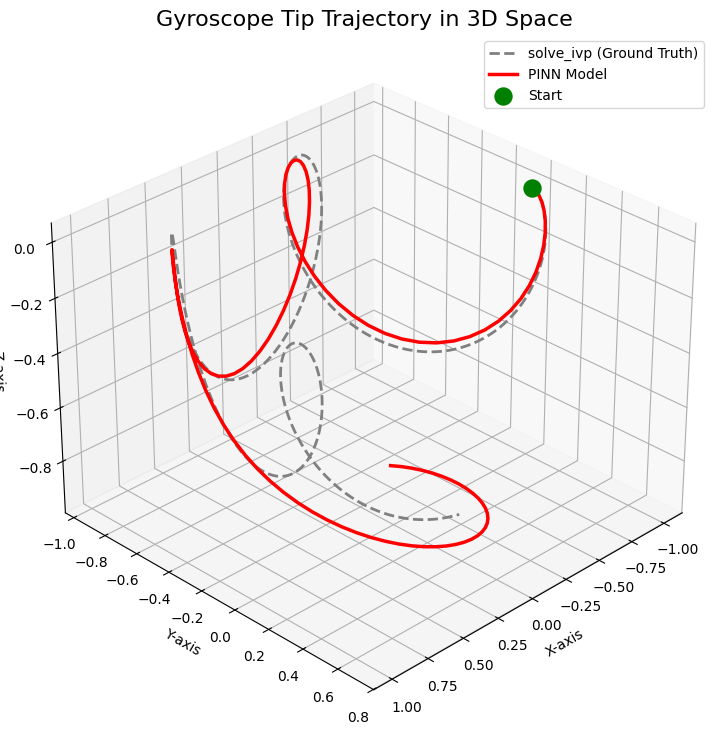

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

if 'output' not in locals() or 'output_sim' not in locals():
    print("Please run the previous cells to generate 'output' and 'output_sim' data.")
else:
    L = 1.0

    theta_sim = output_sim[:, 0]
    phi_sim = output_sim[:, 1]

    x_sim = L * np.sin(theta_sim) * np.cos(phi_sim)
    y_sim = L * np.sin(theta_sim) * np.sin(phi_sim)
    z_sim = L * np.cos(theta_sim)

    theta_model = output[:, 0]
    phi_model = output[:, 1]

    phi_offset = phi_model[0] - phi_sim[0]
    phi_model_corrected = phi_model - phi_offset

    x_model = L * np.sin(theta_model) * np.cos(phi_model_corrected)
    y_model = L * np.sin(theta_model) * np.sin(phi_model_corrected)
    z_model = L * np.cos(theta_model)

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_sim, y_sim, z_sim, label='solve_ivp (Ground Truth)', color='gray', linestyle='--', linewidth=2)
    ax.plot(x_model, y_model, z_model, label='PINN Model', color='red', linewidth=2.5)

    ax.scatter(x_sim[0], y_sim[0], z_sim[0], color='green', s=150, label='Start', marker='o', depthshade=False)

    ax.set_title("Gyroscope Tip Trajectory in 3D Space", fontsize=16)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()
    ax.grid(True)

    ax.view_init(elev=30., azim=45)

    plt.show()
